In [1]:
# pip install -e git+git://github.com/sensiblecodeio/databaker.git@solo-cleaned#egg=databaker

import xlutils
import xypath
import databaker

import databaker.constants
from databaker.constants import *
import databaker.databakersolo as ds
Dcelllookup = ds.overrides.Dcelllookup
batchcelllookup = ds.overrides.batchcelllookup


In [2]:
tableset = xypath.loader.table_set("rftmatables_tcm77-415727.xls", extension='xls')
tabs = list(xypath.loader.get_sheets(tableset, "*"))   

conversionsegments = [ ]
for tab in tabs:
    if tab.name == "Table 1":
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        dimensions = [
            (anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            (anchor.expand(RIGHT).parent().is_not_blank(), 'Companies', CLOSEST, LEFT),
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT),
            (anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank(), 'Transaction', CLOSEST, LEFT),
            (anchor.expand(DOWN).is_not_blank().is_bold(), 'TIMETYPE', CLOSEST, ABOVE)   
        ]
        conversionsegments.append((tab, dimensions, obs))
        
    elif tab.name in ['Table 2', 'Table 3', 'Table 4', 'Table 5']:
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        inv1 = anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank()
        inv1 = inv1 | tab.excel_ref('B4')
        inv1.dimension('Investment', CLOSEST, LEFT)

        dimensions = [
            (anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            (anchor.expand(RIGHT).parent().is_not_blank(), 'Category', CLOSEST, LEFT), 
            (inv1, 'Investment', CLOSEST, LEFT), 
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT), 
            (tab.excel_ref('C1'), 'Category', CLOSEST, ABOVE), 
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), "Measure", CLOSEST, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 6", "Table 7"]:
        
        my_dict = {"6A_Top": 'CBAQ', "6A_Bottom": 'HCL3', "6D_Top": 'CBAS', "6D_Bottom":'HCL5',
                   "7A_Top": 'CBAU', "7A_Bottom": 'HCK7', "7D_Top": 'CBAW', "7D_Bottom":'HCK9'  }
        for P1, corner in my_dict.items():
            if P1[0] != tab.name[-1]:
                continue
    
            anchor = tab.filter(contains_string(corner))
            obs = anchor.shift(DOWN).expand(RIGHT).expand(DOWN).is_not_blank()

            # Getting all the junk out of the file
            unwanted = tab.excel_ref('AA1').expand(DOWN).expand(RIGHT)     
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Area Analysis')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Number')).shift(UP).expand(RIGHT).expand(DOWN)
            obs = obs - unwanted    
            cat = tab.filter(contains_string(P1[0:2])).shift(RIGHT)
            dimensions = [
                (anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Area", CLOSEST, LEFT), 
                (anchor.shift(0, -1).expand(RIGHT).is_not_blank(), MEASURETYPE, DIRECTLY, ABOVE), 
                (anchor.shift(-1, 0).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT),
                (cat, "Mergers", CLOSEST, ABOVE)
            ]
            conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 8", "Table 10"]:
        anchor = tab.excel_ref('C3')
        
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref('R1').expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
        measure_line = anchor.shift(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - measure_line.shift(RIGHT).expand(DOWN)
        
        dimensions = [
            (anchor.expand(RIGHT).is_not_blank(), "Category", CLOSEST, LEFT), 
            (measure_line, MEASURETYPE, DIRECTLY, ABOVE), 
            (anchor.shift(LEFT).expand(DOWN).is_bold(), "TIME - DELETEME", CLOSEST, ABOVE), 
            (anchor.shift(LEFT).expand(DOWN).is_not_bold().is_not_blank(), TIME, DIRECTLY, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))
    
    elif tab.name in ["Table 9"]:
        anchor = tab.filter(contains_string ('Total')).assert_one()

        dimensions = [ 
            (anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Expenditure", CLOSEST, LEFT), 
            
            # this is the one gives the word "cash" and might want to be left or right above, although this is unsatisfactory
            # might be better to be able to displace it to the right (provide an offset) which we can then do CLOSEST RIGHT on
            (anchor.shift(0, -1).expand(RIGHT).is_not_blank(), "Expenditure 1", CLOSEST, LEFT),  
            
            (anchor.expand(RIGHT).is_not_blank(), "Expenditure 2", CLOSEST, LEFT), 
            (anchor.shift(LEFT).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT), 
            (anchor.shift(LEFT).expand(DOWN).is_bold(), "ExtraTime", CLOSEST, ABOVE), 
        ]
        # Get obs,and get rid of lots of crap    
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref("V1").expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ("earliest revision")).expand(RIGHT).expand(DOWN)
        obs = obs - anchor.expand(RIGHT).is_not_blank().shift(RIGHT).fill(DOWN)
        conversionsegments.append((tab, dimensions, obs))

            
print("There are %d conversion segments" % len(conversionsegments))
print([c[0].name for c in conversionsegments])

got header Investment: 1.034s,  1.034s total
got header Investment: 0.020s,  1.054s total
got header Investment: 0.018s,  1.073s total
got header Investment: 0.017s,  1.090s total
There are 16 conversion segments
['Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 6', 'Table 6', 'Table 6', 'Table 7', 'Table 7', 'Table 7', 'Table 7', 'Table 8', 'Table 9', 'Table 10']


In [3]:
# Preview a conversion segment inline or on second screen 
from databaker.jupybakeutils import dsubsets, tabletohtml, sidewindowhtmldisplay, inlinehtmldisplay, incrementdividNUM, inlinehtmljsactive
conversionsegment = conversionsegments[10]
tab, dimensions, segment = conversionsegment
htmtable = tabletohtml(tab, dsubsets(dimensions, segment))

incrementdividNUM()
inlinehtmldisplay(htmtable, hide=False)
inlinehtmljsactive(conversionsegment, batchcelllookup)
#sidewindowhtmldisplay()
#document.getElementsByClassName()



In [4]:

# this currently does the lookups!
allvalues = [ ]

def procbatch(dimvalue, dimlabel):
    if dimlabel == TIME:
        res = [ ]
        for c in dimvalue:
            if c.value == "2010²":
                res.append(2010)
            else:
                res.append(c.value)
        return res
    return [ c.value if c is not None else "" for c in dimvalue ]  # "2010²"

for tab, dimensions, segment in conversionsegments:
    obslist = list(segment.unordered_cells)  # list(segment) otherwise gives bags of one element
    dimvalues = [ procbatch(batchcelllookup(tab, obslist, dimension), dimension[1])  for dimension in dimensions ]
    dtuples = zip(*([procbatch(obslist, OBS)]+dimvalues))
    keys = [OBS] + [ dimension[1]  for dimension in dimensions ]  # the labels
    dvalues = [ dict(zip(keys, dtup))  for dtup in dtuples  if not isinstance(dtup[0], str) ]
    allvalues.extend(dvalues)
    
# In theory we can now call the template export to big CSV, like before at this point
# But now we should seek to plot the stats ourselves as a sanity check that the data is good
        

len(allvalues), allvalues[-1]
#conversionsegments[9][1]


(1955,
 {-6: 'Value',
  'Category': 'Net Transactions in the UK by Foreign Companies¹',
  'TIME - DELETEME': 'Quarterly',
  -2: '2013 Q1 ',
  -9: 3439.0})

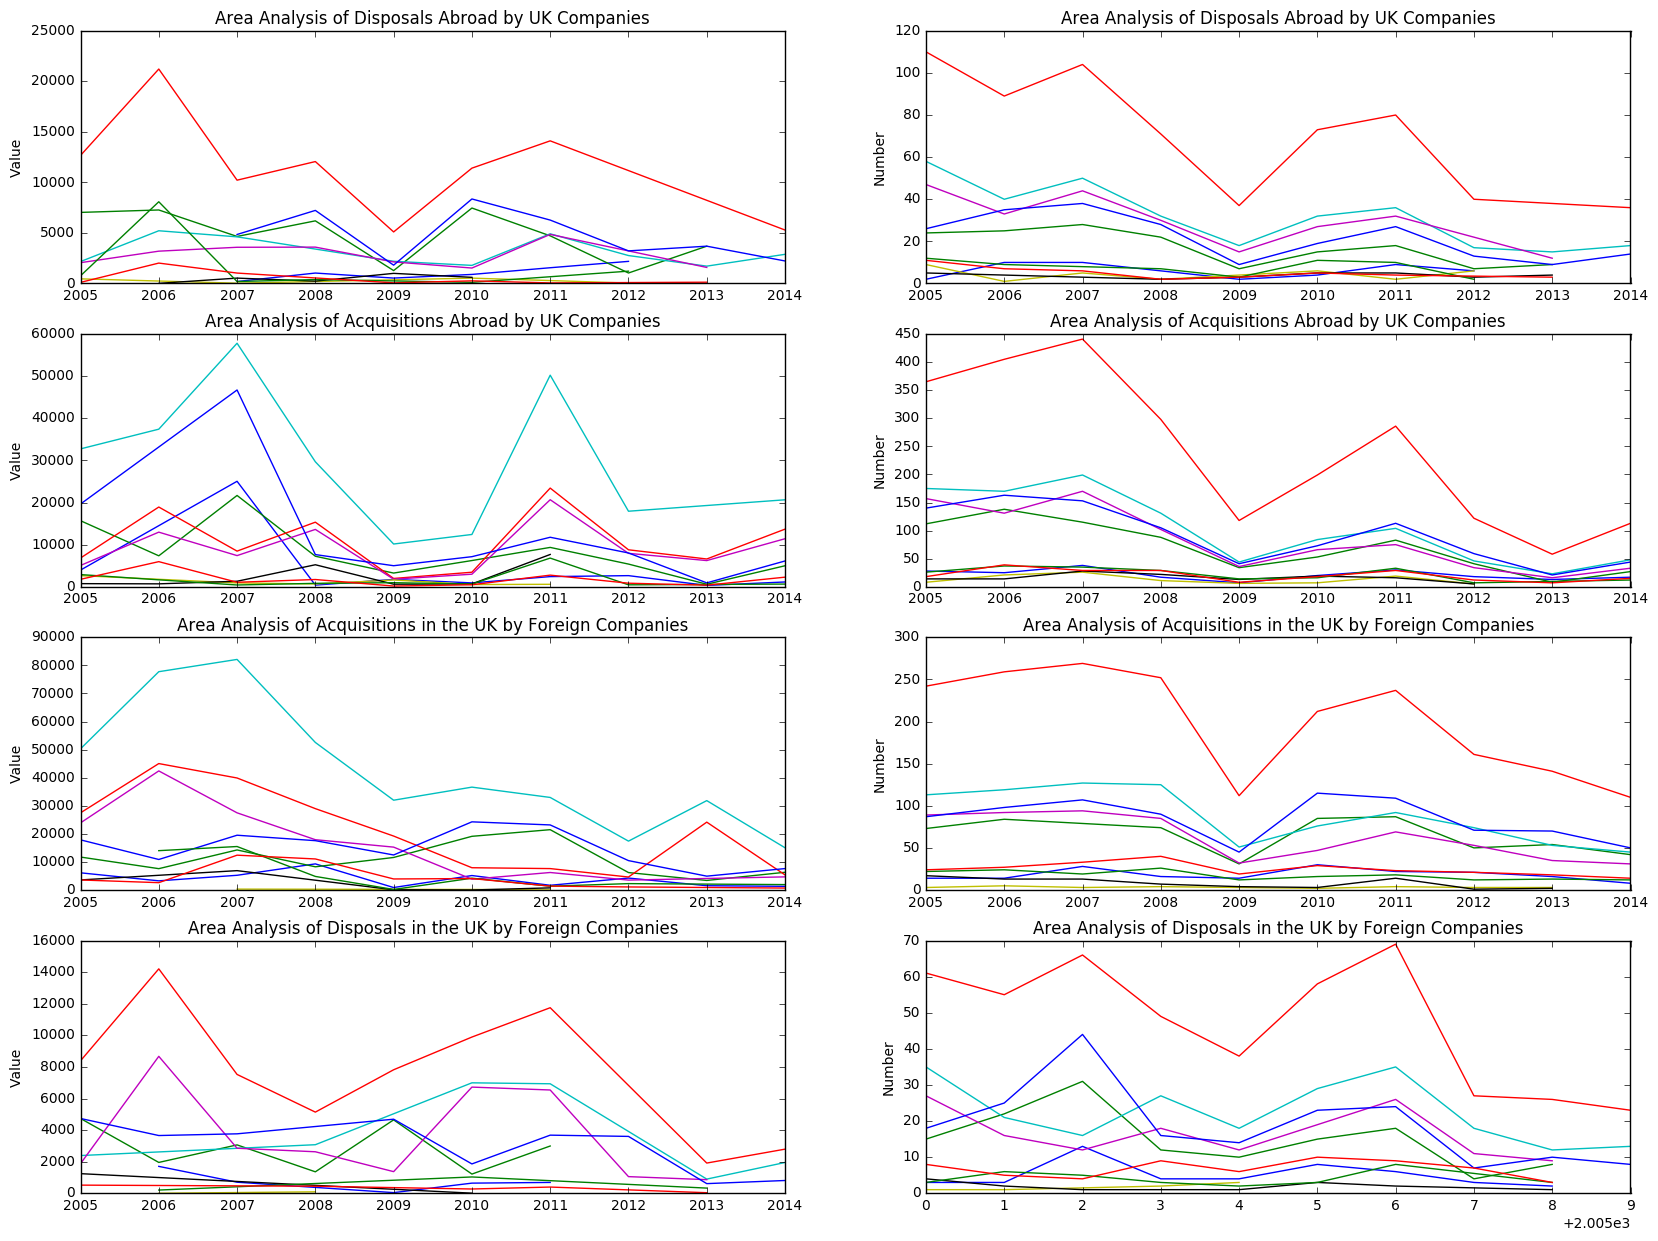

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))

mallvalues = [v  for v in allvalues  if v.get("Mergers")]
MEASURETYPEset = set(v[MEASURETYPE]  for v in mallvalues)
mergerset = set(v["Mergers"]  for v in mallvalues)

for i, merger in enumerate(mergerset):
    for j, sMEASURETYPE in enumerate(MEASURETYPEset):
        values = [v  for v in mallvalues  if (v["Mergers"] == merger and v[MEASURETYPE] == sMEASURETYPE) ]
        areas = set(v['Area']  for v in values)

        ax = plt.gca()
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax.get_xaxis().get_major_formatter().set_scientific(False)

        plt.subplot(len(mergerset), len(MEASURETYPEset), i*len(MEASURETYPEset)+j+1)
        def pairplot(plt, vp, label):
            vp.sort()
            plt.plot([v[0] for v in vp], [v[1] for v in vp], label=label)
        for area in areas:
            pairplot(plt, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == sMEASURETYPE], area)
        #plt.legend()
        #print(merger, sMEASURETYPE, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == "Value"])
        #break
        plt.title(values[0]["Mergers"])
        plt.ylabel(sMEASURETYPE)
plt.show()


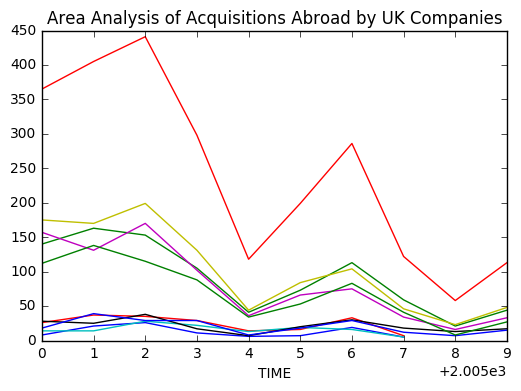

In [18]:
# alternatively, using pivot table (made by Peter)
import pandas as pd
df = ( 
    pd.DataFrame.from_records(mallvalues)
    .rename(columns={-6:"MEASURETYPE", -2:"TIME", -9:"OBS"})
    .assign(TIME=lambda df:df.TIME.astype(int))
    #.assign(TIME2=lambda df:df.TIME.astype(int)*2)
)

pdf = df.pivot_table("OBS", ["TIME"], ["Mergers", "MEASURETYPE", "Area"])
# ["Area Analysis of Acquisitions Abroad by UK Companies"].xs("Number", level="MEASURETYPE", axis=1).plot()
acqtypes = pdf.columns.get_level_values(0).unique()
valtypes = pdf.columns.get_level_values(1).unique()

acqtype = acqtypes[0]
valtype = valtypes[0]
pdf[acqtype][valtype].plot(legend=False, title=acqtype)
